<a href="https://colab.research.google.com/github/my-tech123/Assignment-1-energy/blob/main/wallmart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Data loaded successfully: 6435 rows, 8 columns

--- Dataset Overview ---
   Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0        42.31       2.572   
1      1  12-02-2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0        39.93       2.514   
3      1  26-02-2010    1409727.59             0        46.63       2.561   
4      1  05-03-2010    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106  

--- Checking Missing Values ---
Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

--- Feature engineering ---
✅ Added: year, month, day, week, dayofweek, is_weekend
⚠️ Skipp

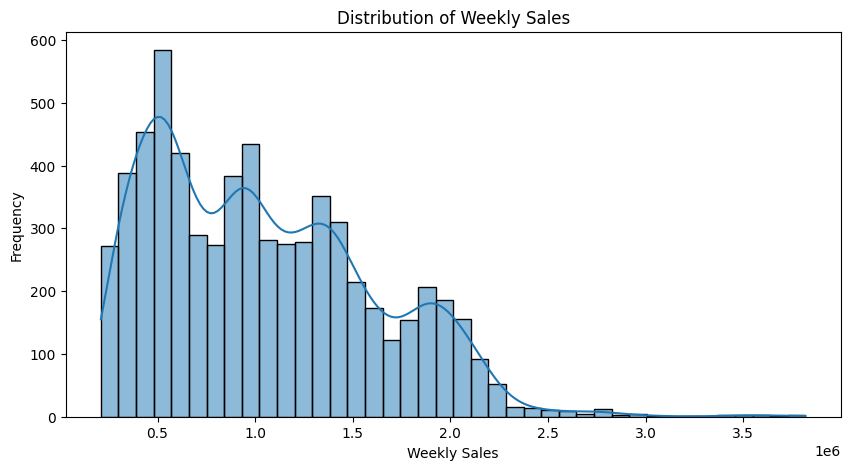

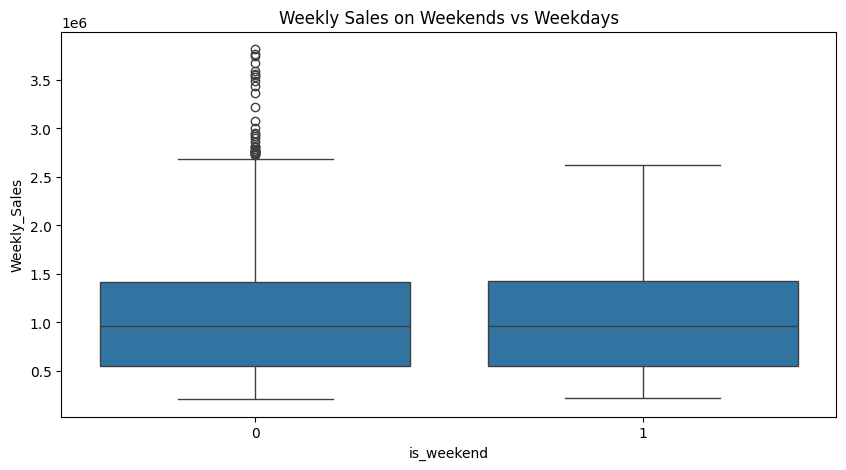

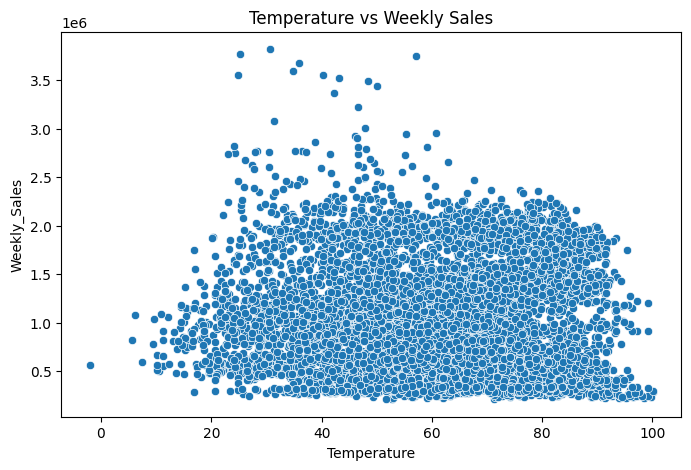


--- Model Preparation ---

--- Training Models ---
LinearRegression: MAE=434173.84, RMSE=524504.46, R2=0.146
Ridge: MAE=434175.82, RMSE=524507.13, R2=0.146
Lasso: MAE=434171.51, RMSE=524505.99, R2=0.146
RandomForest: MAE=72406.48, RMSE=146664.18, R2=0.933
GradientBoosting: MAE=104673.25, RMSE=167879.27, R2=0.913

--- Model Performance Summary ---
                            MAE           RMSE        R2
LinearRegression  434173.839721  524504.459523  0.146047
Ridge             434175.817514  524507.129601  0.146038
Lasso             434171.510405  524505.986263  0.146042
RandomForest       72406.475802  146664.180381  0.933230
GradientBoosting  104673.253540  167879.268321  0.912516


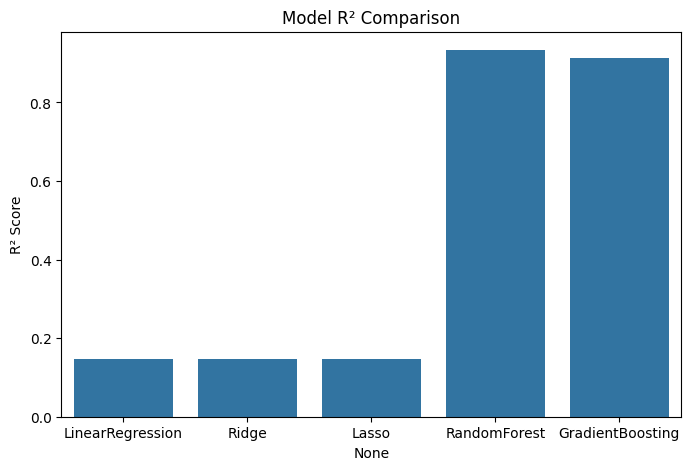


✅ Script completed successfully! Results saved to model_performance_summary.csv.


In [24]:
"""
📊 Walmart Sales Regression – End-to-End Python Script
Author: ChatGPT
Dataset: Wallmart_Sales.csv
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")

DATA_PATH = "Wallmart_Sales.csv"

try:
    df = pd.read_csv(DATA_PATH)
    print(f"✅ Data loaded successfully: {df.shape[0]} rows, {df.shape[1]} columns")
except FileNotFoundError:
    raise SystemExit(f"❌ Data file not found at '{DATA_PATH}'. Please check the path.")

print("\n--- Dataset Overview ---")
print(df.head())

print("\n--- Checking Missing Values ---")
print(df.isnull().sum())

# Fill missing values
for col in df.columns:
    if df[col].dtype in ["int64", "float64"]:
        df[col].fillna(df[col].median(), inplace=True)
    else:
        df[col].fillna(df[col].mode()[0], inplace=True)

print("\n--- Feature engineering ---")
DATE_COLUMN = 'Date'
if DATE_COLUMN not in df.columns:
    raise SystemExit("❌ 'Date' column not found in dataset.")

df[DATE_COLUMN] = pd.to_datetime(df[DATE_COLUMN], errors='coerce')
df['year'] = df[DATE_COLUMN].dt.year
df['month'] = df[DATE_COLUMN].dt.month
df['day'] = df[DATE_COLUMN].dt.day
iso_calendar = df[DATE_COLUMN].dt.isocalendar()
df['week'] = iso_calendar.week.fillna(0).astype(int)
df['dayofweek'] = df[DATE_COLUMN].dt.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

print("✅ Added: year, month, day, week, dayofweek, is_weekend")

# Lag and rolling mean features
if {'Store', 'Dept', 'Weekly_Sales'}.issubset(df.columns):
    group_cols = ['Store', 'Dept']
    df = df.sort_values(by=group_cols + [DATE_COLUMN])
    df['Weekly_Sales_Lag1'] = df.groupby(group_cols)['Weekly_Sales'].shift(1)
    df['Weekly_Sales_RollingMean4'] = (
        df.groupby(group_cols)['Weekly_Sales']
        .transform(lambda x: x.rolling(window=4, min_periods=1).mean())
    )
    print("✅ Created lag and rolling features grouped by", group_cols)
else:
    print("⚠️ Skipped lag/rolling features — required columns missing.")

# Visualization
plt.figure(figsize=(10, 5))
sns.histplot(df['Weekly_Sales'], bins=40, kde=True)
plt.title("Distribution of Weekly Sales")
plt.xlabel("Weekly Sales")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x='is_weekend', y='Weekly_Sales', data=df)
plt.title("Weekly Sales on Weekends vs Weekdays")
plt.show()

if 'Temperature' in df.columns and 'Weekly_Sales' in df.columns:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x='Temperature', y='Weekly_Sales', data=df)
    plt.title("Temperature vs Weekly Sales")
    plt.show()

print("\n--- Model Preparation ---")
X = df.drop(columns=['Weekly_Sales', 'Date'], errors='ignore')
X = pd.get_dummies(X, drop_first=True)
y = df['Weekly_Sales']

# 🧹 Clean remaining missing values before model training
X = X.fillna(0)
y = y.fillna(y.median())

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n--- Training Models ---")
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=150, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    results[name] = [mae, rmse, r2]
    print(f"{name}: MAE={mae:.2f}, RMSE={rmse:.2f}, R2={r2:.3f}")

results_df = pd.DataFrame(results, index=['MAE', 'RMSE', 'R2']).T
print("\n--- Model Performance Summary ---")
print(results_df)

plt.figure(figsize=(8, 5))
sns.barplot(x=results_df.index, y=results_df['R2'])
plt.title("Model R² Comparison")
plt.ylabel("R² Score")
plt.show()

results_df.to_csv("model_performance_summary.csv", index=True)
print("\n✅ Script completed successfully! Results saved to model_performance_summary.csv.")
